In [436]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans


from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.model_selection import GridSearchCV

# USE sagemaker.xgboost when using AWS

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

---
## User-Defined Functions

In [437]:
# Purposedfully omitted
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

---
## Data Preprocessing and EDA

C:\Users\morga\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


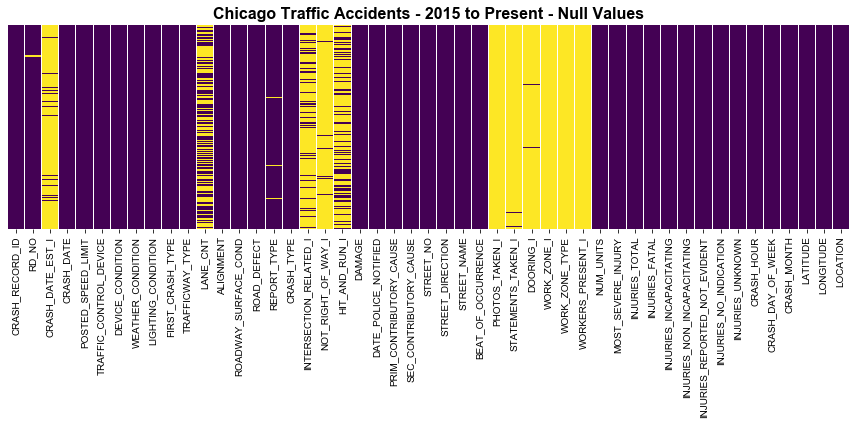

In [438]:
accidents = pd.read_csv('data/traffic_crashes.csv')
plt.figure(figsize=(12,6))
sns.heatmap(accidents.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Chicago Traffic Accidents - 2015 to Present - Null Values', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('chi_accidents_null.png');

In [439]:
# Develop classification flag.
# Positive represents the accideent resulted in incapacitation and/or fatality.
accidents['crash_date'] = pd.to_datetime(accidents['CRASH_DATE'])
accidents['crash_year'] = accidents['crash_date'].dt.year
accidents['fatal_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'FATAL', 1, 0)
accidents['incap_bool'] = np.where(accidents['MOST_SEVERE_INJURY'] == 'INCAPACITATING INJURY', 1, 0)
accidents['fatal_incap'] = accidents['fatal_bool'] + accidents['incap_bool']
accidents.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,crash_date,crash_year,fatal_bool,incap_bool,fatal_incap
0,00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e79...,JC201794,NaN,03/27/2019 04:20:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,...,4,3,41.994704,-87.699395,POINT (-87.699395085278 41.994703544264),2019-03-27 16:20:00,2019,0,0,0
1,0002fb938eb0feaea33820fa55b71e4ea0b332125e1510...,JB175900,NaN,03/06/2018 03:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,3,3,41.904671,-87.716685,POINT (-87.716685434641 41.904671135876),2018-03-06 15:00:00,2018,0,0,0
2,0003fc68d857da032b1beafa8f7893ce0b123ce6b2dee5...,HZ488533,NaN,10/25/2016 02:10:00 PM,30,TRAFFIC SIGNAL,UNKNOWN,CLEAR,DAYLIGHT,REAR END,...,3,10,41.706808,-87.642771,POINT (-87.642771373276 41.706807861572),2016-10-25 14:10:00,2016,0,0,0
3,00060f93d2ae8d4e4c7fe75ac17055dd69a081d0b928a5...,JD123586,NaN,01/21/2020 04:16:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,...,3,1,41.791610,-87.703356,POINT (-87.703355598231 41.791609871969),2020-01-21 16:16:00,2020,0,0,0
4,0006882952e53c291df267014a03b57684383e9ad66d9e...,JC459747,NaN,10/04/2019 12:00:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,6,10,41.848490,-87.675599,POINT (-87.67559940405 41.848490427751),2019-10-04 12:00:00,2019,0,0,0


In [ ]:
# 

In [313]:
# Started collecting data for the entire city in September 2017.
# Data collection became more formalized.
# Omitting data prior to March 2020 due to Covid-19 pandemic.
accidents = accidents[(accidents['crash_date'] > '2017-08-31') & (accidents['crash_date'] < '2020-03-01')]
len(accidents)

292080

In [314]:
num_pos_obs = sum(accidents['fatal_incap'])
num_neg_obs = len(accidents['fatal_incap']) - num_pos_obs
print("# of POSITIVE Obs.: ", num_pos_obs)
print("# of NEGATIVE Obs.: ", num_neg_obs)
print("% of Positive Obs. (Fatalities): ", round(sum(accidents['fatal_incap']) / len(accidents['fatal_incap']), 4))

# of POSITIVE Obs.:  5358
# of NEGATIVE Obs.:  286722
% of Positive Obs. (Fatalities):  0.0183


Returns True if Total Accidents Reconcile:  True


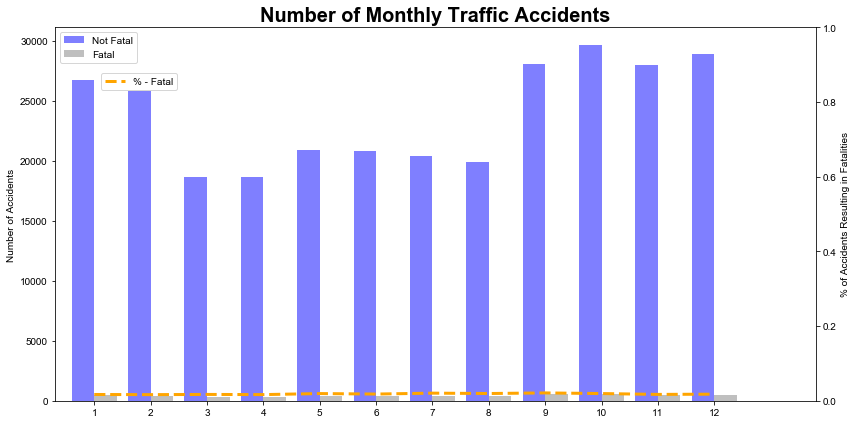

In [38]:
# Create data frame
month_grpd = accidents.groupby(['CRASH_MONTH', 'fatal_incap']).agg({'fatal_incap':'count'})
month_grpd.columns = ['count']
month_grpd.reset_index(inplace=True)
month_no_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 0]
month_fatal_incap = month_grpd[month_grpd['fatal_incap'] == 1]

month_fatal_df = pd.DataFrame()
month_fatal_df['month'] = pd.Series(range(1,13))
month_fatal_df['num_not_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 0]['count'])
month_fatal_df['num_fatal'] = np.array(month_grpd[month_grpd['fatal_incap'] == 1]['count'])
month_fatal_df['total'] = month_fatal_df['num_not_fatal'] + month_fatal_df['num_fatal']
month_fatal_df['prcnt_fatal'] = month_fatal_df['num_fatal'] / month_fatal_df['total']

pos = list(range(len(month_fatal_df['month'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos, month_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos], month_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos])
ax1.set_xticklabels(month_fatal_df['month'])
ax1.set_title('Number of Monthly Traffic Accidents', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, 13)

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos], month_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(month_fatal_df['total'])==len(accidents)))

Returns TRUE if Total # of Accidents Reconcile:  True


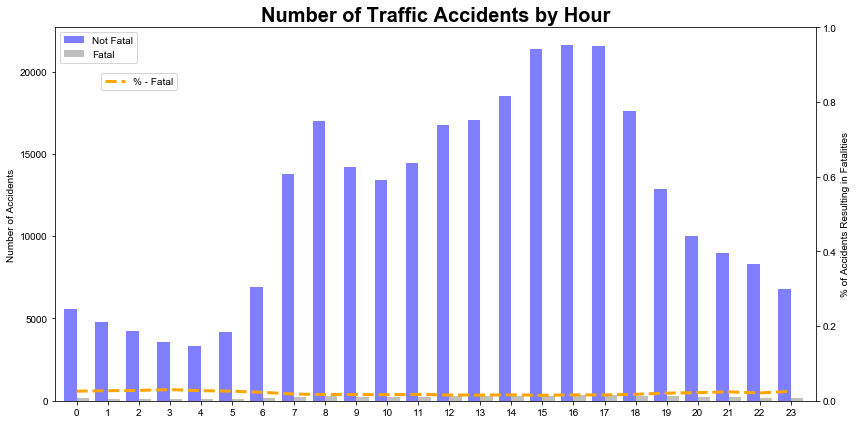

In [176]:
# Compare Hourly Data

hour_grpd = accidents.groupby(['CRASH_HOUR', 'fatal_incap']).agg({'fatal_incap':'count'})
hour_grpd.columns = ['count']
hour_grpd.reset_index(inplace=True)
hour_no_fatal = hour_grpd[hour_grpd['fatal_incap'] == 0]
hour_fatal_ = hour_grpd[hour_grpd['fatal_incap'] == 1]

hour_fatal_df = pd.DataFrame()
hour_fatal_df['hour'] = pd.Series(range(0,24))
hour_fatal_df['num_not_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 0]['count'])
hour_fatal_df['num_fatal'] = np.array(hour_grpd[hour_grpd['fatal_incap'] == 1]['count'])
hour_fatal_df['total'] = hour_fatal_df['num_not_fatal'] + hour_fatal_df['num_fatal']
hour_fatal_df['prcnt_fatal'] = hour_fatal_df['num_fatal'] / hour_fatal_df['total']

pos_hour = list(range(len(hour_fatal_df['hour'])))
width = 0.4


# Create
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos_hour, hour_fatal_df['num_not_fatal'], width, alpha=0.5, color='b', label='Not Fatal')
ax1.bar([p + width for p in pos_hour], hour_fatal_df['num_fatal'], width, alpha=0.5, color='grey', label='Fatal')
ax1.set_ylabel('Number of Accidents')
ax1.set_xticks([p + 0.5 * width for p in pos_hour])
ax1.set_xticklabels(hour_fatal_df['hour'])
ax1.set_title('Number of Traffic Accidents by Hour', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, len(hour_fatal_df))

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Accidents Resulting in Fatalities')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos_hour], hour_fatal_df['prcnt_fatal'] , color='orange', linestyle='--', linewidth=3, 
         label='% - Fatal')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

# check math
print("Returns TRUE if Total # of Accidents Reconcile: ", (sum(hour_fatal_df['total'])==len(accidents)))

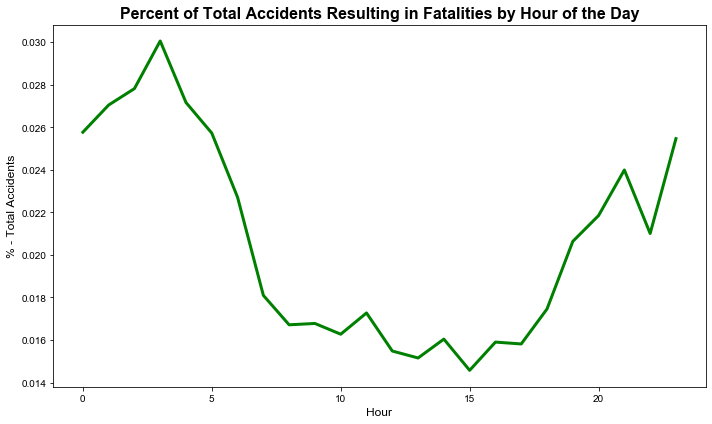

In [187]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pos_hour, hour_fatal_df['prcnt_fatal'] , color='green',  linewidth=3)
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Hour of the Day', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
fig.tight_layout()

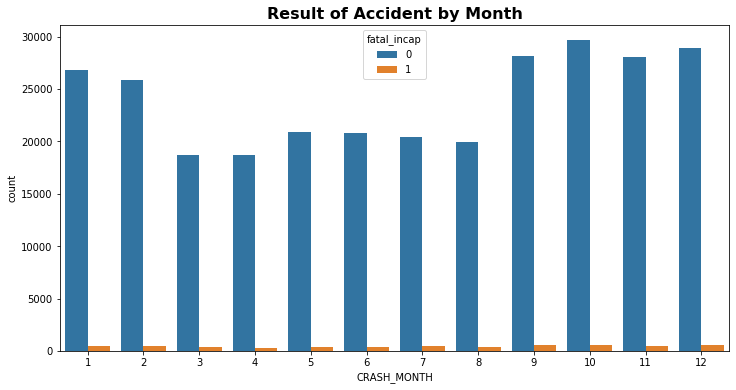

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='CRASH_MONTH', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Month", fontsize=16, fontweight='bold');

In [44]:
accidents.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

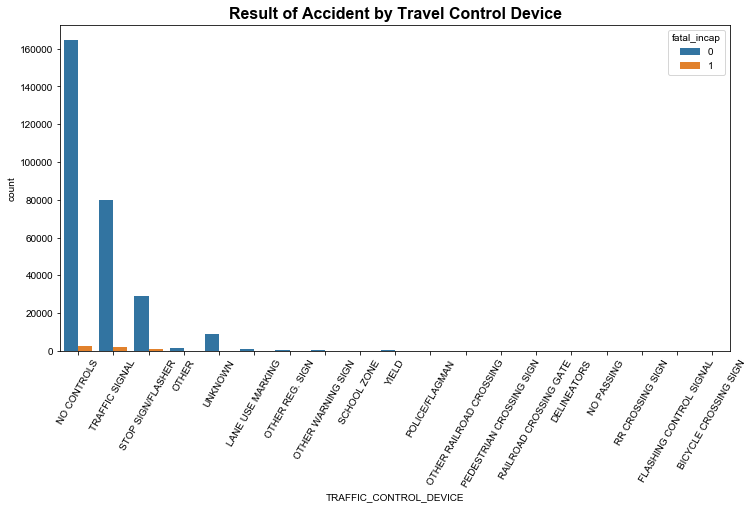

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(x='TRAFFIC_CONTROL_DEVICE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

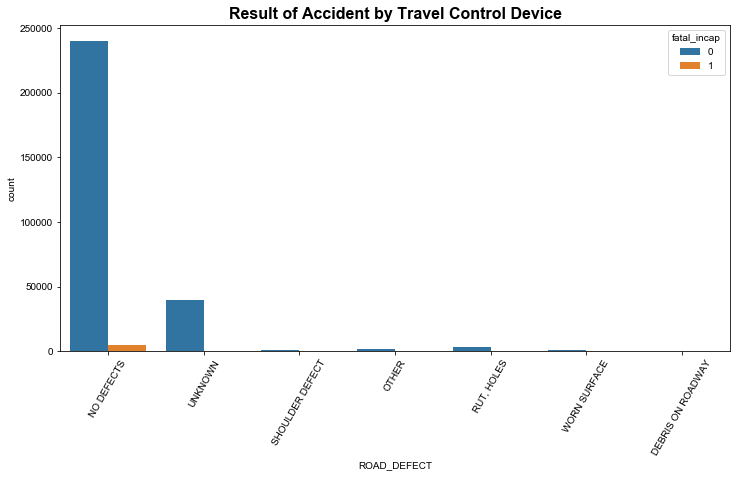

In [48]:
plt.figure(figsize=(12,6))
sns.countplot(x='ROAD_DEFECT', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

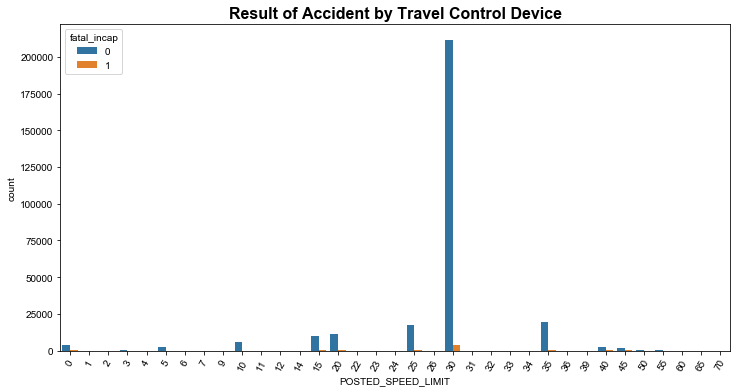

In [49]:
accidents_speed_limt = accidents[accidents['POSTEDS_SPEED_']]
plt.figure(figsize=(12,6))
sns.countplot(x='POSTED_SPEED_LIMIT', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

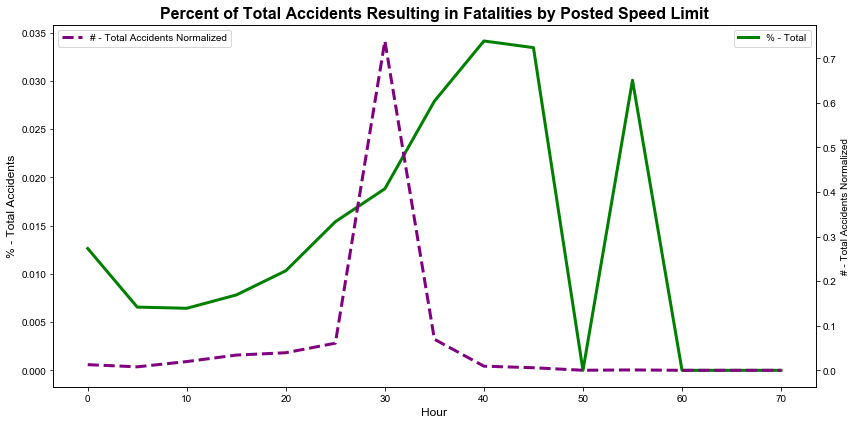

In [290]:
accidents_spd_lim = accidents[accidents['POSTED_SPEED_LIMIT'] % 5 == 0].copy()
spd_lim_pivot = accidents_spd_lim.pivot_table(index='POSTED_SPEED_LIMIT', columns='fatal_incap', values='CRASH_RECORD_ID',
                                              fill_value=0, aggfunc='count').reset_index()
#spd_lim_pivot.drop('fatal_incap', axis=1, inplace=True)
spd_lim_pivot.rename({0:'num_not_fatal', 1:'num_fatal'}, axis=1, inplace=True)
spd_lim_pivot['total'] = spd_lim_pivot['num_not_fatal'] + spd_lim_pivot['num_fatal']
spd_lim_pivot['prcnt_fatal'] = spd_lim_pivot['num_fatal'] / spd_lim_pivot['total']

fig, ax = plt.subplots(figsize=(12,6))
spd_arr = spd_lim_pivot['POSTED_SPEED_LIMIT'].values
spd_prcnt_fatal_arr = spd_lim_pivot['prcnt_fatal'].values
spd_total_arr_nrml = spd_lim_pivot['total'].values / sum(spd_lim_pivot['total'])

ax.plot(spd_arr, spd_prcnt_fatal_arr , color='green',  linewidth=3, label='% - Total')
ax.set_title('Percent of Total Accidents Resulting in Fatalities by Posted Speed Limit', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('% - Total Accidents', fontsize=12)
ax.legend()

# Share x-axis
ax2=ax.twinx()

#ax2.set_ylim(0, 100000)
ax2.set_ylabel('# - Total Accidents Normalized')
ax2.plot(spd_arr, spd_total_arr_nrml , color='purple', linestyle='--', linewidth=3, 
         label='# - Total Accidents Normalized')

ax2.legend(loc='upper left', facecolor='white')
ax2.grid(color=None, linestyle='None')

fig.tight_layout()

In [271]:
spd_lim_pivot

fatal_incap,POSTED_SPEED_LIMIT,num_not_fatal,num_fatal,total,prcnt_fatal
0,0,3674,47,3721,0.012631
1,5,2274,15,2289,0.006553
2,10,5715,37,5752,0.006433
3,15,9905,78,9983,0.007813
4,20,11410,119,11529,0.010322
5,25,17511,274,17785,0.015406
6,30,211632,4060,215692,0.018823
7,35,19789,568,20357,0.027902
8,40,2631,93,2724,0.034141
9,45,1647,57,1704,0.033451


In [238]:
spd_lim_grpd
#print(range(0,len(spd_lim_grpd)))
#len(spd_lim_grpd[spd_lim_grpd['fatal_incap'] == 0])

,POSTED_SPEED_LIMIT,fatal_incap,count
0,0,0,3674
1,0,1,47
2,5,0,2274
3,5,1,15
4,10,0,5715
5,10,1,37
6,15,0,9905
7,15,1,78
8,20,0,11410
9,20,1,119


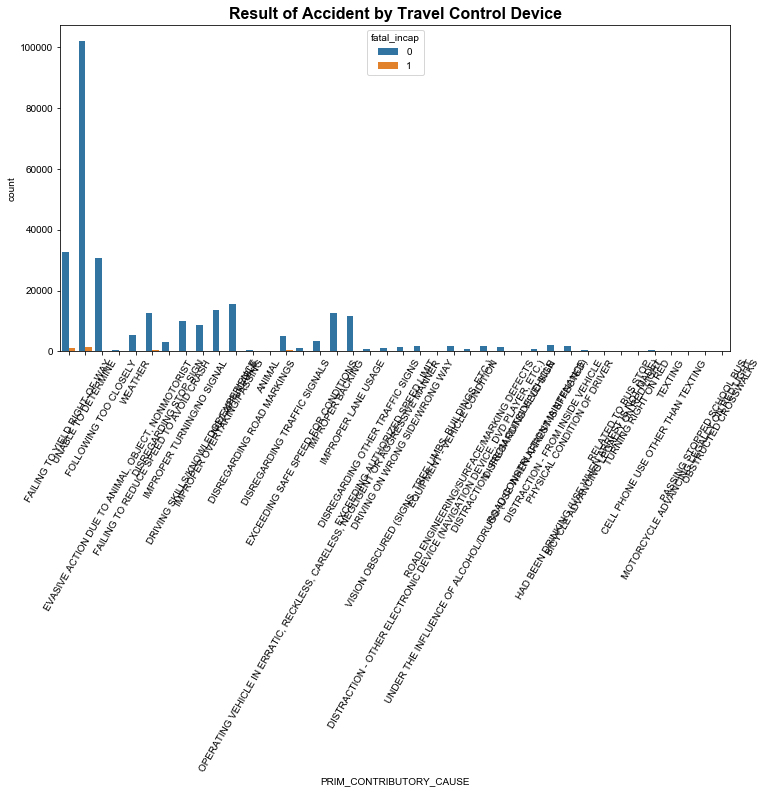

In [50]:
plt.figure(figsize=(12,6))
sns.countplot(x='PRIM_CONTRIBUTORY_CAUSE', data=accidents, hue='fatal_incap')
plt.title("Result of Accident by Travel Control Device", fontsize=16, fontweight='bold')
plt.xticks(rotation=60);

In [57]:
accidents.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

---
# CREATE THE FINAL DATASET

In [461]:
# Excluded "after-the-fact" features, e.g. DAMAGE($), DOORING_I
# Omitted geospatial data, SEC_CONTRIBUTORY_CAUSE, LANE_CNT.
# Construction information does not provide significant value.
accidents2 = accidents[['CRASH_RECORD_ID', 'RD_NO', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                        'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
                        'ALIGNMENT','ROADWAY_SURFACE_COND','ROAD_DEFECT', 'CRASH_TYPE', 
                        'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 
                        'PRIM_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 
                        'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
                        'crash_date', 'crash_year','fatal_incap']].copy()

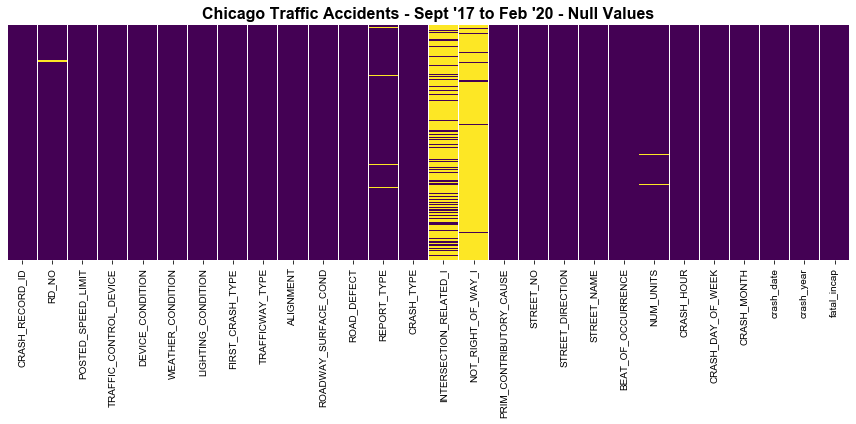

In [462]:
plt.figure(figsize=(12,6))
sns.heatmap(accidents2.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Chicago Traffic Accidents - Sept '17 to Feb '20 - Null Values", fontsize=16, fontweight='bold')
plt.savefig('chi_accidents_null.png');
plt.tight_layout();

In [466]:
accidents['NUM_UNITS'].unique()

array([ 2.,  3.,  1., nan,  4.,  8.,  5.,  6.,  7., 10., 11.,  9., 18.,
       15., 12., 16.])

In [215]:
X_im_train, X_im_test, y_im_train, y_im_test = train_test_split(X_imbl, y_imbl, 
                                                                test_size=0.20, random_state=42)

---
## Create X Subsets for Model Train/Test

#### Variables are imbalanced.

In [463]:
y_all_true = accidents2[['fatal_incap']]

In [449]:
trfc_cntrl.columns

Index(['BICYCLE CROSSING SIGN', 'DELINEATORS', 'FLASHING CONTROL SIGNAL',
       'LANE USE MARKING', 'NO CONTROLS', 'NO PASSING', 'OTHER',
       'OTHER RAILROAD CROSSING', 'OTHER REG. SIGN', 'OTHER WARNING SIGN',
       'PEDESTRIAN CROSSING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE',
       'RR CROSSING SIGN', 'SCHOOL ZONE', 'STOP SIGN/FLASHER',
       'TRAFFIC SIGNAL', 'UNKNOWN', 'YIELD'],
      dtype='object')

In [420]:
# X1
# Rmoving POSTED_SPEED_LIMIT and CRASH_HOUR b/c importance is inflated.
X_1 = accidents[['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION']]
trfc_cntrl = pd.get_dummies(X_1['TRAFFIC_CONTROL_DEVICE'])
wthr_cndtn = pd.get_dummies(X_1['WEATHER_CONDITION'])
lghtng_cndtn = pd.get_dummies(X_1['LIGHTING_CONDITION'])
X_1_dum = pd.concat([X_1, trfc_cntrl, wthr_cndtn, lghtng_cndtn], axis=1)
X_1_dum.drop(['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION'], axis=1, inplace=True)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1_dum.values, y_1.values,test_size=0.20, random_state=42)

In [324]:
X_2 = accidents2[['PRIM_CONTRIBUTORY_CAUSE','ROADWAY_SURFACE_COND','ROAD_DEFECT']]
prime_cause = pd.get_dummies(accidents2['PRIM_CONTRIBUTORY_CAUSE'])
road_surface = pd.get_dummies(accidents2['ROADWAY_SURFACE_COND'])
road_defect = pd.get_dummies(accidents2['ROAD_DEFECT'])
X_2_dum = pd.concat([prime_cause, road_surface, road_defect], axis=1)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2_dum.values, y_1.values,test_size=0.20, random_state=42)

In [445]:
prime_cause.columns

Index(['ANIMAL', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT',
       'CELL PHONE USE OTHER THAN TEXTING', 'DISREGARDING OTHER TRAFFIC SIGNS',
       'DISREGARDING ROAD MARKINGS', 'DISREGARDING STOP SIGN',
       'DISREGARDING TRAFFIC SIGNALS', 'DISREGARDING YIELD SIGN',
       'DISTRACTION - FROM INSIDE VEHICLE',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',
       'DRIVING ON WRONG SIDE/WRONG WAY',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 'EQUIPMENT - VEHICLE CONDITION',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
       'EXCEEDING AUTHORIZED SPEED LIMIT',
       'EXCEEDING SAFE SPEED FOR CONDITIONS',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY',
       'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'IMPROPER BACKING',
       'IMPROPER LANE USAGE', 'IMPROPER OVERTAKING/PASSING',
       'IMPROPER TURNING/NO SIGNAL

In [ ]:
### Use w/ GridSearch

In [468]:
X_3 = accidents[['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION', 
                 'PRIM_CONTRIBUTORY_CAUSE']]
trfc_cntrl_x3 = pd.get_dummies(X_3['TRAFFIC_CONTROL_DEVICE'])
prime_cause_x3= pd.get_dummies(X_3['PRIM_CONTRIBUTORY_CAUSE'])
lghtng_cndtn_x3 = pd.get_dummies(X_3['LIGHTING_CONDITION'])

no_trfc_cntrl_x3= trfc_cntrl_x3[['NO CONTROLS']]
drkns_lghtng_rd_x3 = lghtng_cndtn_x3['DARKNESS, LIGHTED ROAD']
prime_cause_sub_x3 = prime_cause_x3[['DISREGARDING TRAFFIC SIGNALS','FOLLOWING TOO CLOSELY', 'IMPROPER BACKING',
                                     'FAILING TO YIELD RIGHT-OF-WAY']]
x3_concat_lst = [X_3[['POSTED_SPEED_LIMIT', 'CRASH_HOUR']], no_trfc_cntrl_x3, drkns_lghtng_rd_x3, prime_cause_sub_x3]
X_3 = pd.concat(x3_concat_lst, axis=1)
X_3.head()

,POSTED_SPEED_LIMIT,CRASH_HOUR,NO CONTROLS,"DARKNESS, LIGHTED ROAD",DISREGARDING TRAFFIC SIGNALS,FOLLOWING TOO CLOSELY,IMPROPER BACKING,FAILING TO YIELD RIGHT-OF-WAY
0,30,16,1,0,0,0,0,1
1,30,15,1,0,0,0,0,0
2,30,14,0,0,0,0,0,0
3,30,16,1,0,0,0,0,0
4,30,12,0,0,0,1,0,0


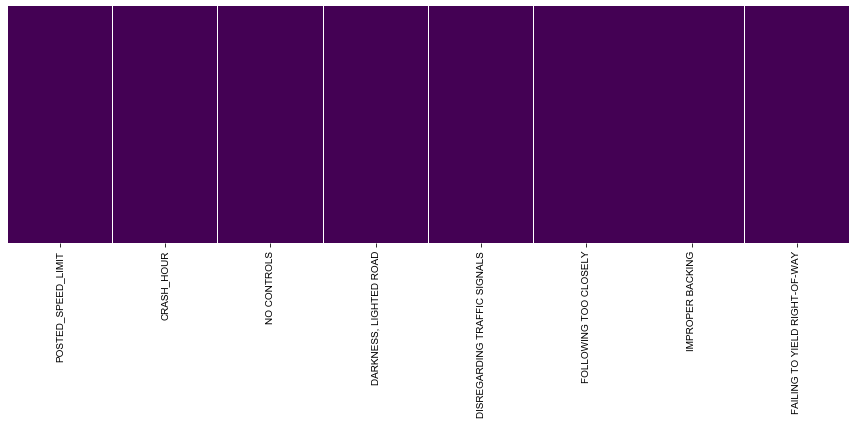

In [470]:
plt.figure(figsize=(12,6))
sns.heatmap(X_3.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout();

---
### XGBoost (Built-in Hyperparameter) - Oversampling - X1

In [411]:
xgboost = XGBClassifier(random_state=1, learning_rate=0.1)
xgboost.fit(X_1_train, y_1_train.ravel())
y_pred_xgb = xgboost.predict(X_1_test)
print(classification_report(y_1_test.ravel(), y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57345
           1       0.00      0.00      0.00      1071

    accuracy                           0.98     58416
   macro avg       0.49      0.50      0.50     58416
weighted avg       0.96      0.98      0.97     58416



C:\Users\morga\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [421]:
xgboost_scld = XGBClassifier(random_state=1, learning_rate=0.1, scale_pos_weight=num_neg_obs/num_pos_obs )
xgboost_scld.fit(X_1_train, y_1_train.ravel())
y_pred_xgb_scld = xgboost_scld.predict(X_1_test)
print(classification_report(y_1_test.ravel(), y_pred_xgb_scld))

              precision    recall  f1-score   support

           0       0.99      0.51      0.67     57345
           1       0.02      0.65      0.05      1071

    accuracy                           0.51     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.51      0.66     58416



In [422]:
for i, col in enumerate(X_1_dum.columns):
    print("f{} = {}".format(i, col))

f0 = BICYCLE CROSSING SIGN
f1 = DELINEATORS
f2 = FLASHING CONTROL SIGNAL
f3 = LANE USE MARKING
f4 = NO CONTROLS
f5 = NO PASSING
f6 = OTHER
f7 = OTHER RAILROAD CROSSING
f8 = OTHER REG. SIGN
f9 = OTHER WARNING SIGN
f10 = PEDESTRIAN CROSSING SIGN
f11 = POLICE/FLAGMAN
f12 = RAILROAD CROSSING GATE
f13 = RR CROSSING SIGN
f14 = SCHOOL ZONE
f15 = STOP SIGN/FLASHER
f16 = TRAFFIC SIGNAL
f17 = UNKNOWN
f18 = YIELD
f19 = BLOWING SAND, SOIL, DIRT
f20 = BLOWING SNOW
f21 = CLEAR
f22 = CLOUDY/OVERCAST
f23 = FOG/SMOKE/HAZE
f24 = FREEZING RAIN/DRIZZLE
f25 = OTHER
f26 = RAIN
f27 = SEVERE CROSS WIND GATE
f28 = SLEET/HAIL
f29 = SNOW
f30 = UNKNOWN
f31 = DARKNESS
f32 = DARKNESS, LIGHTED ROAD
f33 = DAWN
f34 = DAYLIGHT
f35 = DUSK
f36 = UNKNOWN


In [ ]:
X1

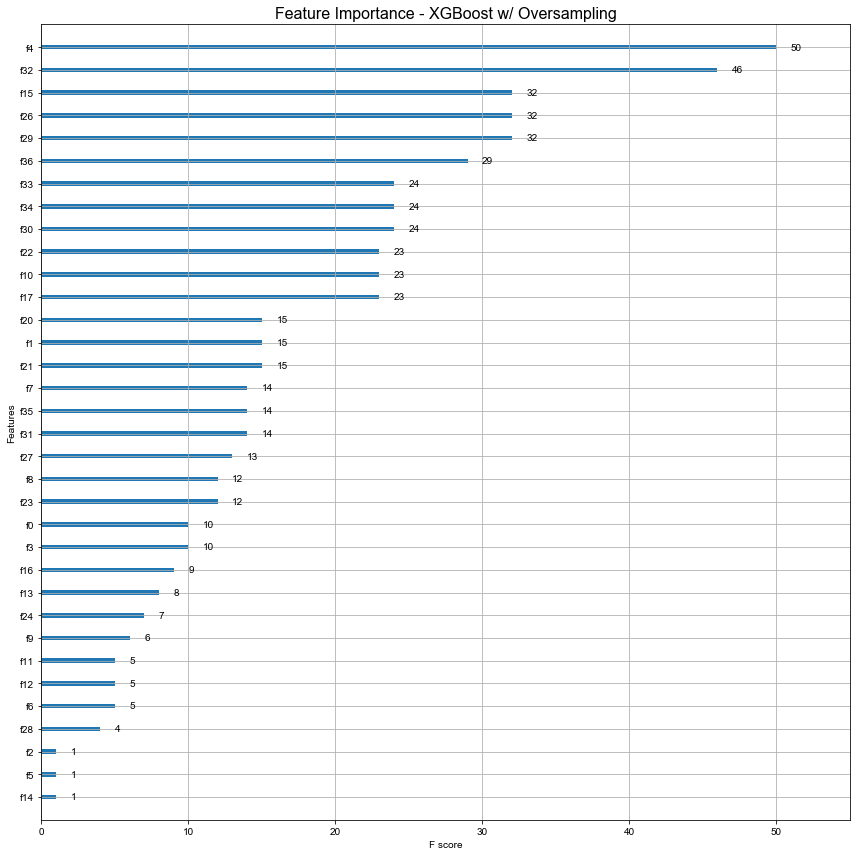

In [423]:
#plt.figure(figsize=(12,6))
#plot_importance(xgboost_scld)

plt.rcParams['figure.figsize'] = (12,12)
plot_importance(xgboost_scld)#.set_yticklabels(reversed(X_1_dum.columns))
# plt.yticks(label=X_1_dum.columns)
plt.title("Feature Importance - XGBoost w/ Oversampling", fontsize=16)
plt.tight_layout();

---
### XGBoost (Built-in Hyperparameter) - Oversampling - X2 

#### Primary Cause, Roadway Condition and Road Defect

In [326]:
xgboost_scld_2 = XGBClassifier(random_state=1, learning_rate=0.1, scale_pos_weight=num_neg_obs/num_pos_obs )
xgboost_scld_2.fit(X_2_train, y_2_train.ravel())
y_2_pred_xgb_scld = xgboost_scld_2.predict(X_2_test)
print(classification_report(y_2_test.ravel(), y_2_pred_xgb_scld))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     57345
           1       0.04      0.58      0.07      1071

    accuracy                           0.73     58416
   macro avg       0.51      0.66      0.46     58416
weighted avg       0.97      0.73      0.83     58416



In [388]:
for i, col in enumerate(X_2_dum.columns):
    print("f{} = {}".format(i, col))

f0 = ANIMAL
f1 = BICYCLE ADVANCING LEGALLY ON RED LIGHT
f2 = CELL PHONE USE OTHER THAN TEXTING
f3 = DISREGARDING OTHER TRAFFIC SIGNS
f4 = DISREGARDING ROAD MARKINGS
f5 = DISREGARDING STOP SIGN
f6 = DISREGARDING TRAFFIC SIGNALS
f7 = DISREGARDING YIELD SIGN
f8 = DISTRACTION - FROM INSIDE VEHICLE
f9 = DISTRACTION - FROM OUTSIDE VEHICLE
f10 = DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)
f11 = DRIVING ON WRONG SIDE/WRONG WAY
f12 = DRIVING SKILLS/KNOWLEDGE/EXPERIENCE
f13 = EQUIPMENT - VEHICLE CONDITION
f14 = EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST
f15 = EXCEEDING AUTHORIZED SPEED LIMIT
f16 = EXCEEDING SAFE SPEED FOR CONDITIONS
f17 = FAILING TO REDUCE SPEED TO AVOID CRASH
f18 = FAILING TO YIELD RIGHT-OF-WAY
f19 = FOLLOWING TOO CLOSELY
f20 = HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)
f21 = IMPROPER BACKING
f22 = IMPROPER LANE USAGE
f23 = IMPROPER OVERTAKING/PASSING
f24 = IMPROPER TURNING/NO SIGNAL
f25 = MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT
f26

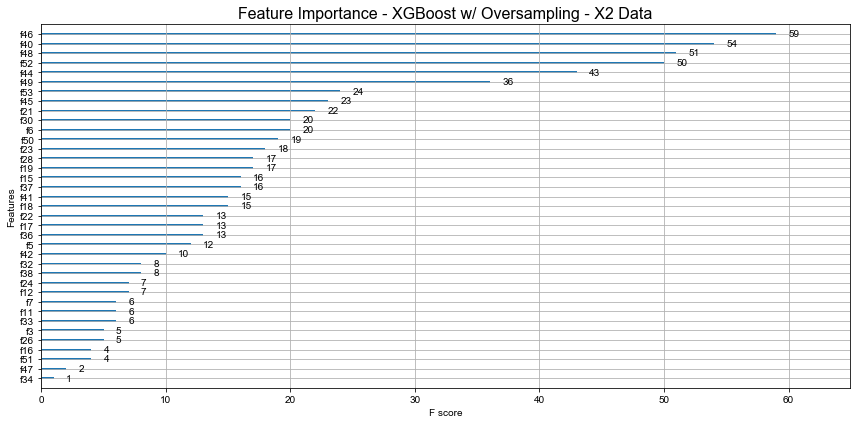

In [387]:
plt.rcParams['figure.figsize'] = (12,6)
plot_importance(xgboost_scld_2)#.set_yticklabels(X_2_dum.columns)
plt.title("Feature Importance - XGBoost w/ Oversampling - X2 Data", fontsize=16)
plt.tight_layout();

---
### SMOTE / Gradient Boost - X1 Dataset

In [197]:
oversampler = SMOTE(random_state=0, k_neighbors=5)
X_1_train_os, y_1_train_os = oversampler.fit_sample(X_1_train, y_1_train.ravel())

#print(y_1_train.shape, y_1_train_os.shape)
print(np.bincount(y_1_train[0]), np.bincount(y_1_train_os))

[1] [229377 229377]


In [198]:
print("BEFORE SMOTE(oversampler)")
print("# of Depedent Variables", len(y_1_train))
print("# of Positive Depedent Variables",sum(y_1_train))
print("% of Total Dependents Variables that are Postive", sum(y_1_train)/len(y_1_train))
print("\n")
print("AFTER SMOTE(oversampler)")
print("# of Depedent Variables", len(y_1_train_os))
print("# of Postive Depedent Variables",sum(y_1_train_os))
print("% of Total Dependents Variables that are Postive", sum(y_1_train_os)/len(y_1_train_os))

BEFORE SMOTE(oversampler)
# of Depedent Variables 233664
# of Positive Depedent Variables [4287]
% of Total Dependents Variables that are Postive [0.01834686]


AFTER SMOTE(oversampler)
# of Depedent Variables 458754
# of Postive Depedent Variables 229377
% of Total Dependents Variables that are Postive 0.5


In [199]:
# Gradient Boost (NO oversampler)
gdbt_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
gdbt_model.fit(X_1_train, y_1_train.ravel())
y_1_pred_gdbt = gdbt_model.predict(X_1_test)
print(classification_report(y_1_test.ravel(), y_1_pred_gdbt))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57345
           1       0.00      0.00      0.00      1071

    accuracy                           0.98     58416
   macro avg       0.49      0.50      0.50     58416
weighted avg       0.96      0.98      0.97     58416



In [200]:
# Gradient Boost  oversampler)
gdbt_model_os = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
gdbt_model_os.fit(X_1_train_os, y_1_train_os.ravel())
y_1_pred_gdbt_os = xgbt_model_os.predict(X_1_test)
print(classification_report(y_1_test.ravel(), y_1_pred_gdbt_os))

              precision    recall  f1-score   support

           0       0.99      0.60      0.74     57345
           1       0.03      0.56      0.05      1071

    accuracy                           0.60     58416
   macro avg       0.51      0.58      0.40     58416
weighted avg       0.97      0.60      0.73     58416



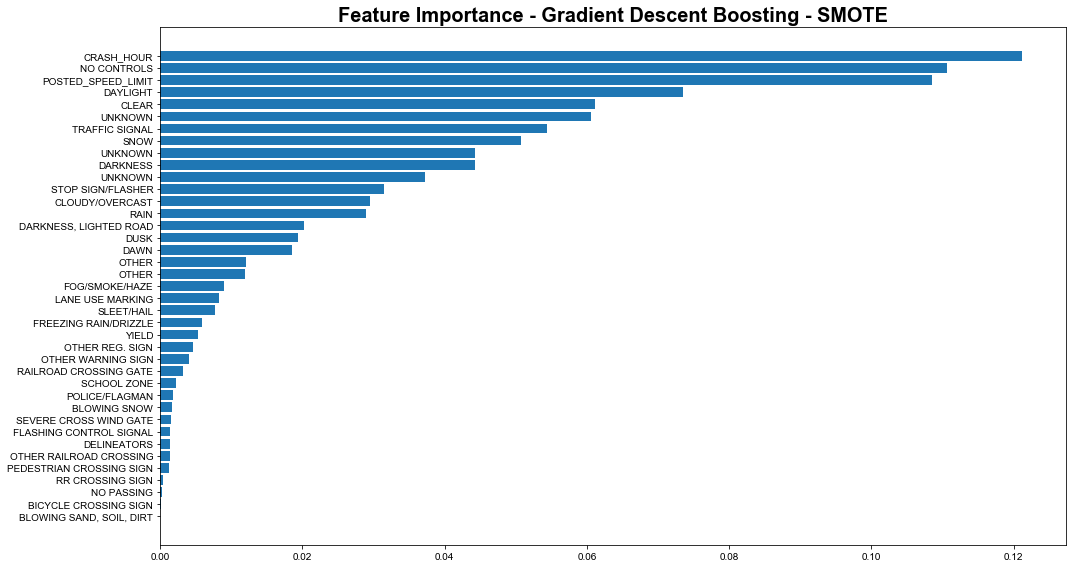

In [351]:
# "NO CONTROLS" is a variable of the "TRAFFIC_CONTROL_DEVICE"
gdbt_os_feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gdbt_model_os.feature_importances_}, 
                                   index=X_1_dum.columns)
gdbt_os_feat_scores = gdbt_os_feat_scores.sort_values(by='Fraction of Samples Affected')

fig, ax = plt.subplots(figsize=(15,8))
pos = np.arange(1, len(gdbt_os_feat_scores)+1)
ax.barh(y=pos, width=gdbt_os_feat_scores['Fraction of Samples Affected'])
       
ax.set_title("Feature Importance - Gradient Descent Boosting - SMOTE", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(pos)
ax.set_yticklabels(labels=gdbt_os_feat_scores.index)

fig.tight_layout();

In [202]:
accidents2['TRAFFIC_CONTROL_DEVICE'].unique()

array(['NO CONTROLS', 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'OTHER',
       'UNKNOWN', 'LANE USE MARKING', 'OTHER REG. SIGN',
       'OTHER WARNING SIGN', 'SCHOOL ZONE', 'YIELD', 'POLICE/FLAGMAN',
       'OTHER RAILROAD CROSSING', 'PEDESTRIAN CROSSING SIGN',
       'RAILROAD CROSSING GATE', 'DELINEATORS', 'NO PASSING',
       'RR CROSSING SIGN', 'FLASHING CONTROL SIGNAL',
       'BICYCLE CROSSING SIGN'], dtype=object)

---
### Gradient Boost - SMOTE - X2 Dataset

In [336]:
smote_os_2 = SMOTE(random_state=0, k_neighbors=5)
X_2_train_os, y_2_train_os = smote_os_2.fit_sample(X_2_train, y_2_train.ravel())

gdbt_model_os_2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
gdbt_model_os_2.fit(X_2_train_os, y_2_train_os.ravel())
y_2_pred_gdbt_os = gdbt_model_os_2.predict(X_2_test)
print(classification_report(y_2_test.ravel(), y_2_pred_gdbt_os))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     57345
           1       0.04      0.53      0.07      1071

    accuracy                           0.76     58416
   macro avg       0.51      0.64      0.47     58416
weighted avg       0.97      0.76      0.84     58416



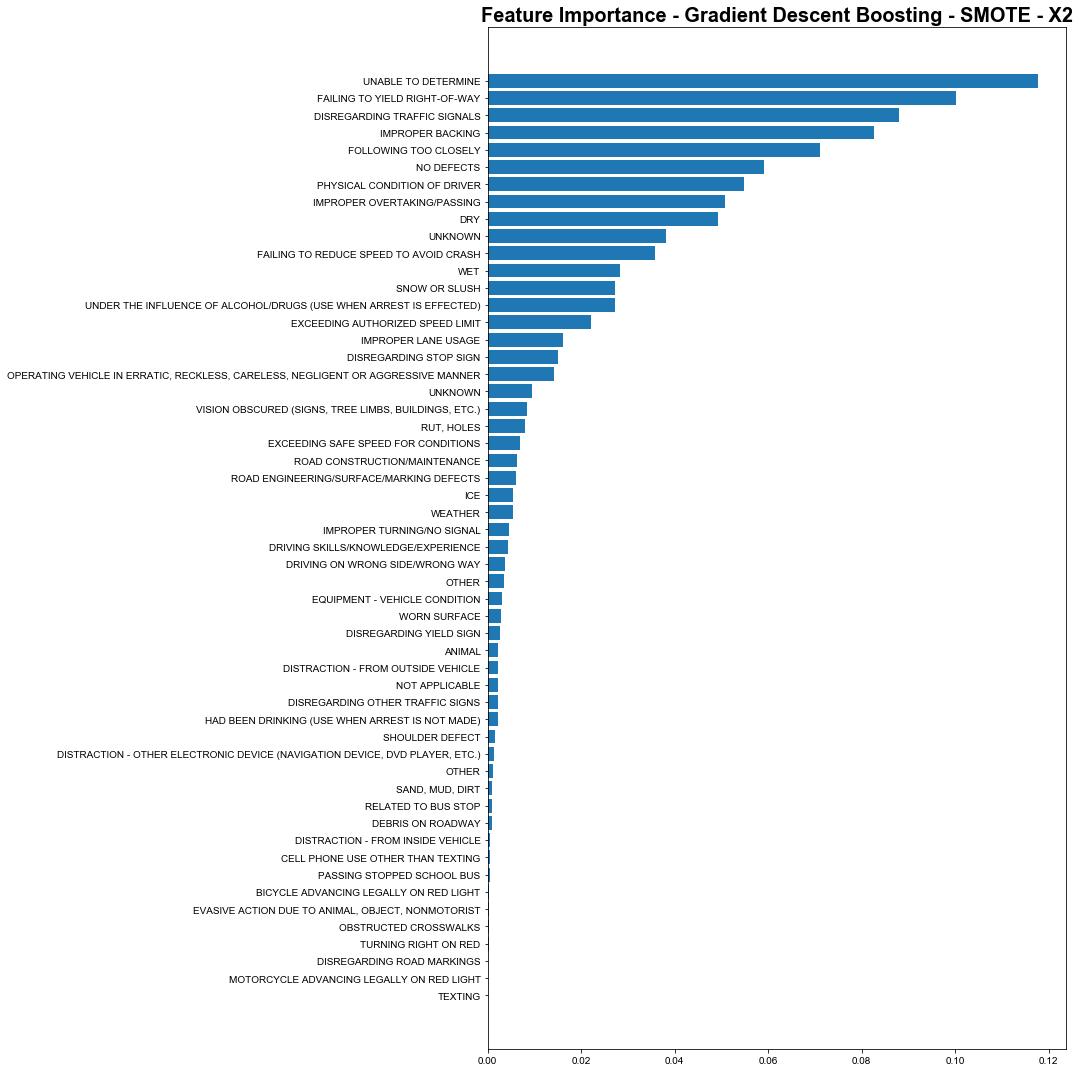

In [350]:
gdbt_os_2_feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gdbt_model_os_2.feature_importances_}, 
                                   index=X_2_dum.columns)
gdbt_os_2_feat_scores = gdbt_os_2_feat_scores.sort_values(by='Fraction of Samples Affected')

fig, ax = plt.subplots(figsize=(15,15))
pos_gdbt_2 = np.arange(1, len(gdbt_os_2_feat_scores)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=pos_gdbt_2, width=gdbt_os_2_feat_scores['Fraction of Samples Affected'])
       
ax.set_title("Feature Importance - Gradient Descent Boosting - SMOTE - X2", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(pos_gdbt_2)
ax.set_yticklabels(labels=gdbt_os_2_feat_scores.index)

fig.tight_layout();

---
### Random Forest - Oversampling - X1

In [424]:
rndm_os = RandomOverSampler(random_state=0)
rndm_os.fit(X_1_train, y_1_train.ravel())
X_train_rndm_os, y_train_rndm_os = rndm_os.fit_resample(X_1_train, y_1_train.ravel())

rf_rndm_os = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_os.fit(X_train_rndm_os, y_train_rndm_os)
y_pred_rndm_os = rf_rndm_os.predict(X_1_test)
print(classification_report(y_1_test.ravel(), y_pred_rndm_os))

              precision    recall  f1-score   support

           0       0.99      0.51      0.67     57345
           1       0.02      0.64      0.05      1071

    accuracy                           0.51     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.51      0.66     58416



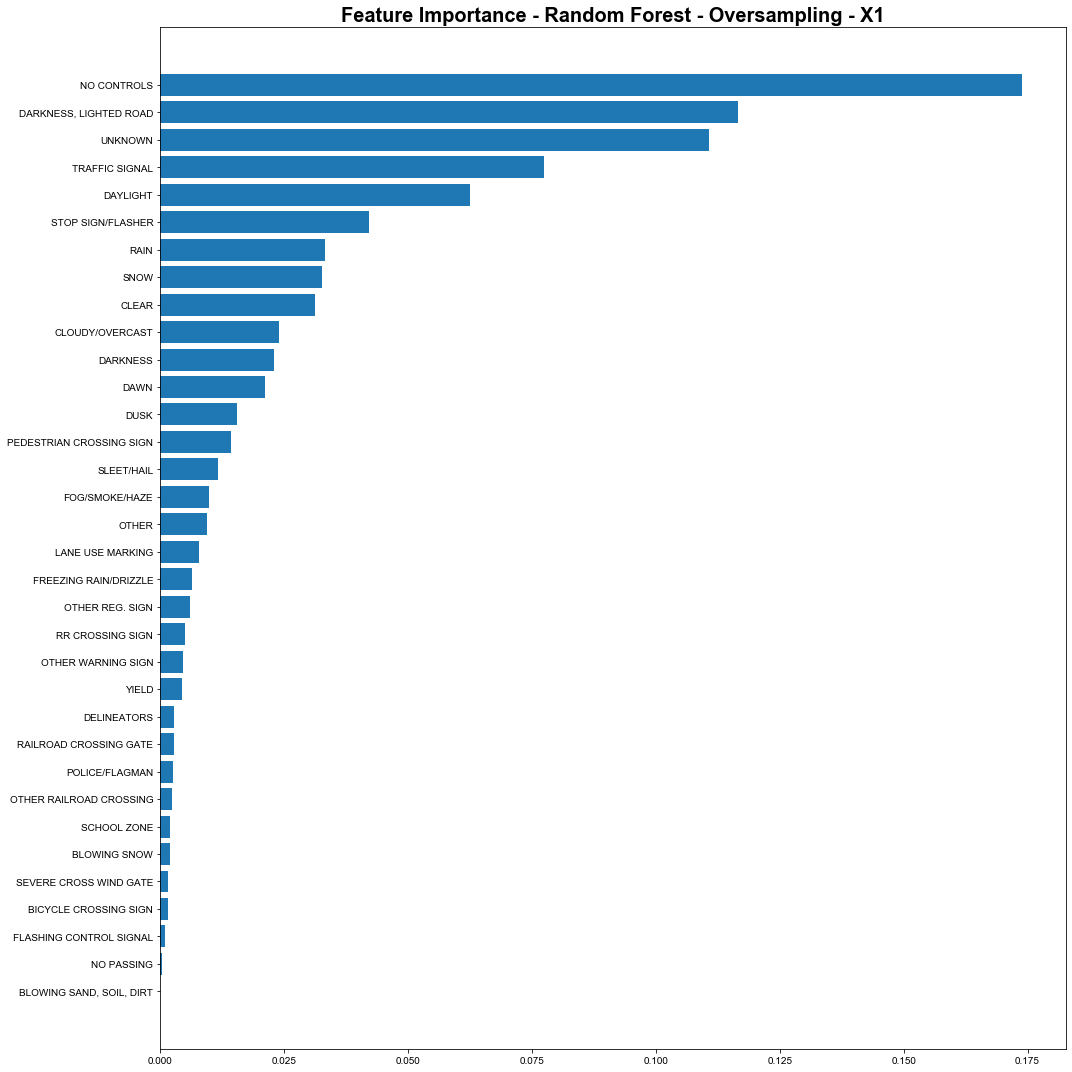

In [425]:
feat_imp_rf_os_1 = rf_rndm_os.feature_importances_
dct_imp_rf_os_1 = {}
for feat, val in zip(X_1_dum.columns, feat_imp_rf_os_1):
    dct_imp_rf_os_1[feat] = val
df_imp_rf_os_1 = pd.DataFrame(dct_imp_rf_os_1, index=[0]).unstack().reset_index()
df_imp_rf_os_1.drop('level_1', axis=1, inplace=True)
df_imp_rf_os_1.columns= ['feature', 'feat_importance']

df_imp_rf_os_1 = df_imp_rf_os_1.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_os_1)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_os_1['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Oversampling - X1", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_os_1['feature'])

fig.tight_layout();

---
### Random Forest - Oversampling - X2

In [333]:
# Replacement is off.
rndm_os_2 = RandomOverSampler(random_state=0)
rndm_os_2.fit(X_2_train, y_2_train.ravel())
X_2_train_rndm_os, y_2_train_rndm_os = rndm_os_2.fit_resample(X_2_train, y_2_train.ravel())

rf_rndm_os_2 = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_os_2.fit(X_2_train_rndm_os, y_2_train_rndm_os.ravel())
y_2_pred_rndm_os = rf_rndm_os_2.predict(X_2_test)
print(classification_report(y_2_test.ravel(), y_2_pred_rndm_os))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83     57345
           1       0.04      0.58      0.07      1071

    accuracy                           0.71     58416
   macro avg       0.51      0.64      0.45     58416
weighted avg       0.97      0.71      0.81     58416



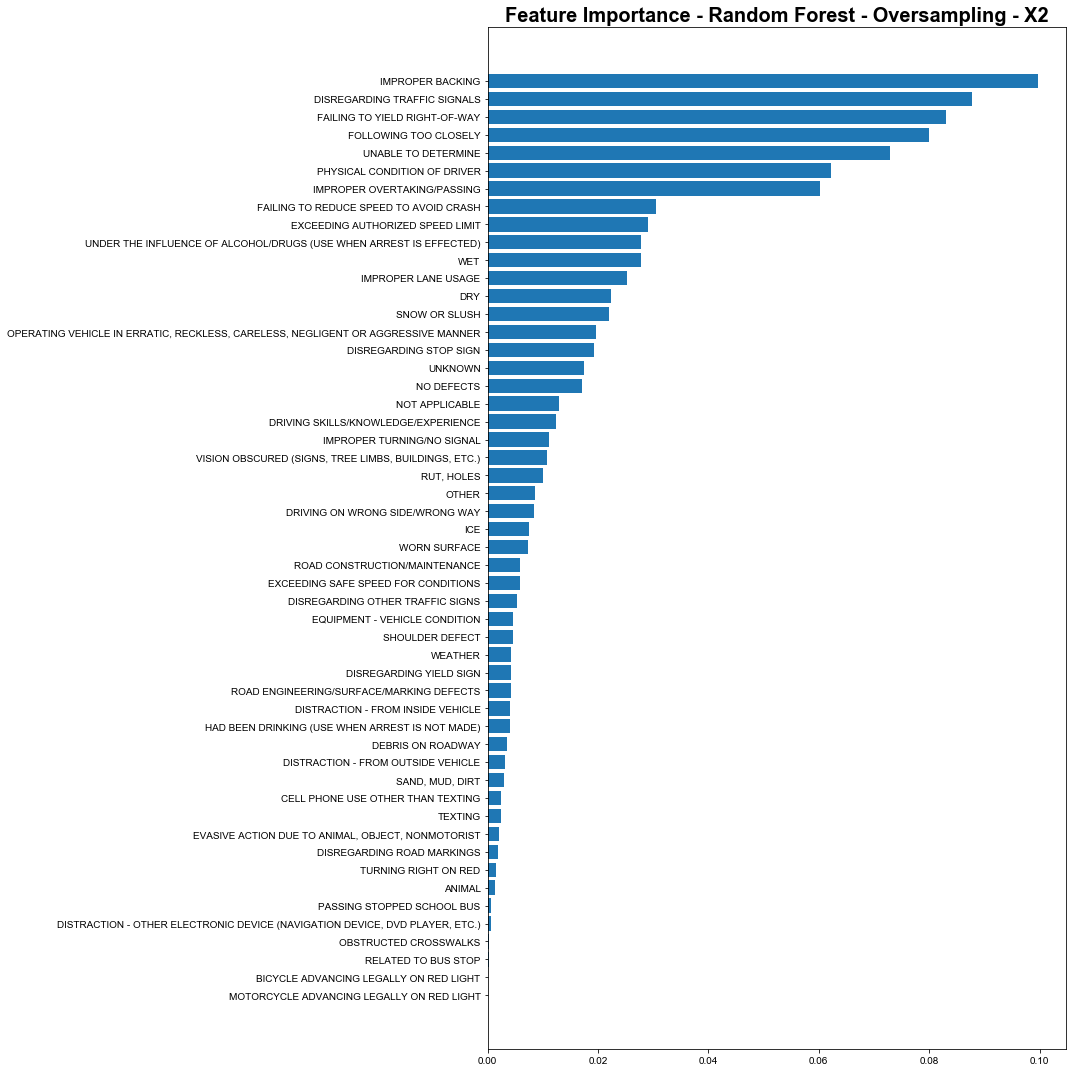

In [383]:
feat_imp_rf_os_2 = rf_rndm_os_2.feature_importances_
dct_imp_rf_os_2 = {}
for feat, val in zip(X_2_dum.columns, feat_imp_rf_os_2):
    dct_imp_rf_os_2[feat] = val
df_imp_rf_os_2 = pd.DataFrame(dct_imp_rf_os_2, index=[0]).unstack().reset_index()
df_imp_rf_os_2.drop('level_1', axis=1, inplace=True)
df_imp_rf_os_2.columns= ['feature', 'feat_importance']
df_imp_rf_os_2 = df_imp_rf_os_2.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_os_2)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_os_2['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Oversampling - X2", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_os_2['feature'])

fig.tight_layout();

---
### Logistic Regression - Oversampling - X1

In [426]:
std_scaler = StandardScaler()
X_1_train_rndm_os_scld = std_scaler.fit_transform(X_train_rndm_os)
X_1_test_scld = std_scaler.transform(X_1_test)

log_reg_1 = LogisticRegression(solver='lbfgs').fit(X_1_train_rndm_os_scld, y_train_rndm_os.ravel())
y_1_pred_log = log_reg_1.predict(X_1_test_scld)
print(classification_report(y_1_test.ravel(), y_1_pred_log))

              precision    recall  f1-score   support

           0       0.99      0.50      0.67     57345
           1       0.02      0.66      0.05      1071

    accuracy                           0.51     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.51      0.65     58416



---
### Logistic Regression - Oversampling - X2

In [361]:
std_scaler = StandardScaler()
X_2_train_rndm_os_scld = std_scaler.fit_transform(X_2_train_rndm_os)
X_2_test_scld = std_scaler.transform(X_2_test)

log_reg_2 = LogisticRegression(solver='lbfgs').fit(X_2_train_rndm_os_scld, y_train_rndm_os.ravel())
y_2_pred_log = log_reg_2.predict(X_2_test_scld)
print(classification_report(y_2_test.ravel(), y_2_pred_log))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     57345
           1       0.04      0.57      0.07      1071

    accuracy                           0.74     58416
   macro avg       0.51      0.65      0.46     58416
weighted avg       0.97      0.74      0.83     58416



---
# Undersampling

---
### Random Forest - Undersampling - X1


In [427]:
rndm_us = RandomUnderSampler(random_state=0)
rndm_us.fit(X_1_train, y_1_train.ravel())
X_train_rndm_us, y_train_rndm_us = rndm_us.fit_resample(X_1_train, y_1_train.ravel())

rf_rndm_us = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_us.fit(X_train_rndm_us, y_train_rndm_us.ravel())
y_pred_rndm_us = rf_rndm_us.predict(X_1_test)
print(classification_report(y_1_test.ravel(), y_pred_rndm_us))

              precision    recall  f1-score   support

           0       0.99      0.51      0.67     57345
           1       0.02      0.65      0.05      1071

    accuracy                           0.51     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.51      0.66     58416



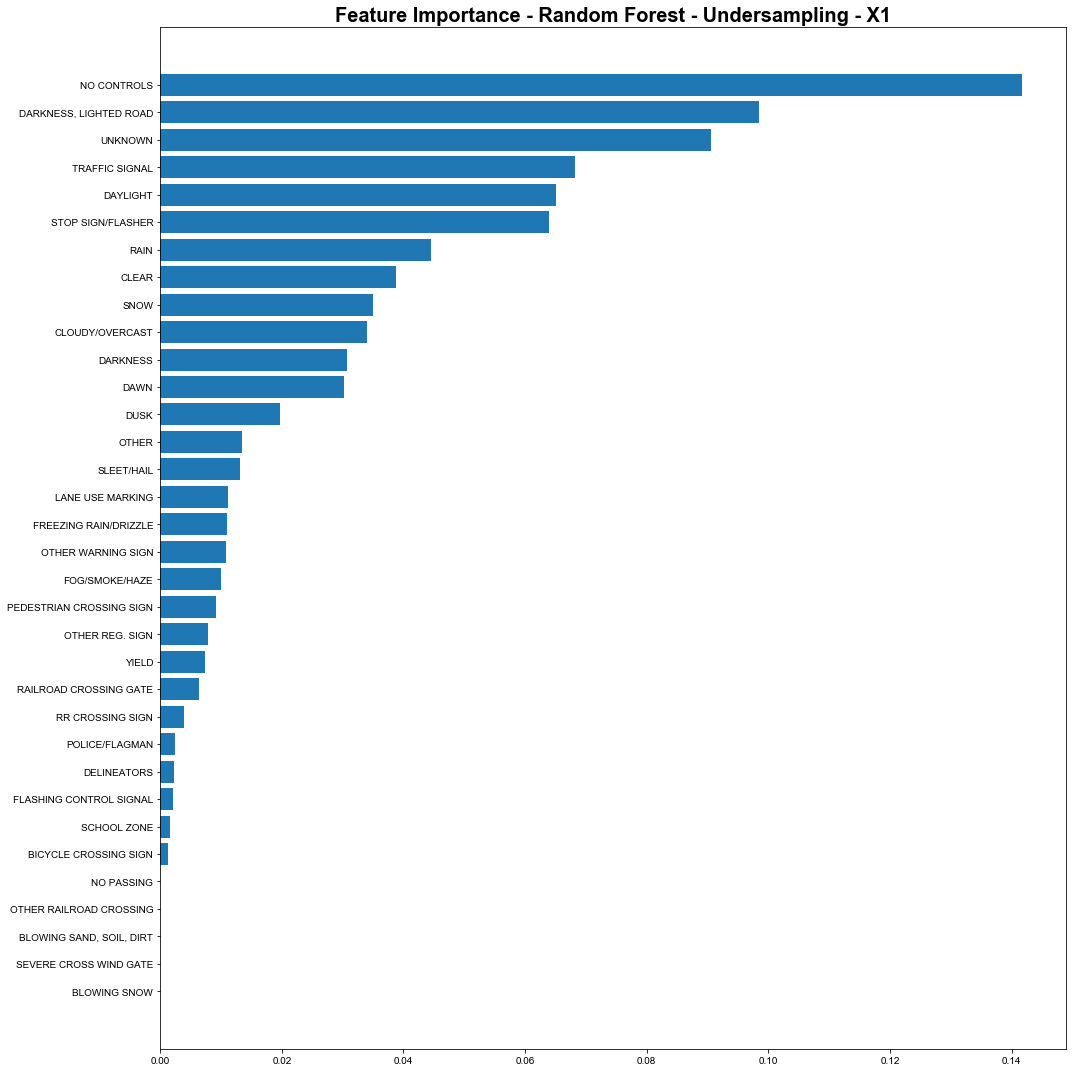

In [428]:
feat_imp_rf_us_1 = rf_rndm_us.feature_importances_
dct_imp_rf_us_1 = {}
for feat, val in zip(X_1_dum.columns, feat_imp_rf_us_1):
    dct_imp_rf_us_1[feat] = val
df_imp_rf_us_1 = pd.DataFrame(dct_imp_rf_us_1, index=[0]).unstack().reset_index()
df_imp_rf_us_1.drop('level_1', axis=1, inplace=True)
df_imp_rf_us_1.columns= ['feature', 'feat_importance']

df_imp_rf_us_1 = df_imp_rf_us_1.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_us_1)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_us_1['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Undersampling - X1", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_us_1['feature'])

fig.tight_layout();

---
### Random Forest - Undersampling - X2

In [334]:
rndm_us_2 = RandomUnderSampler(random_state=0)
rndm_us_2.fit(X_2_train, y_2_train.ravel())
X_2_train_rndm_us, y_2_train_rndm_us = rndm_us_2.fit_resample(X_2_train, y_2_train.ravel())

rf_rndm_us_2 = RandomForestClassifier(random_state=1, n_estimators=100)
rf_rndm_us_2.fit(X_2_train_rndm_us, y_2_train_rndm_us.ravel())
y_2_pred_rndm_us = rf_rndm_us_2.predict(X_2_test)
print(classification_report(y_2_test.ravel(), y_2_pred_rndm_us))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     57345
           1       0.04      0.60      0.07      1071

    accuracy                           0.69     58416
   macro avg       0.51      0.65      0.44     58416
weighted avg       0.97      0.69      0.80     58416



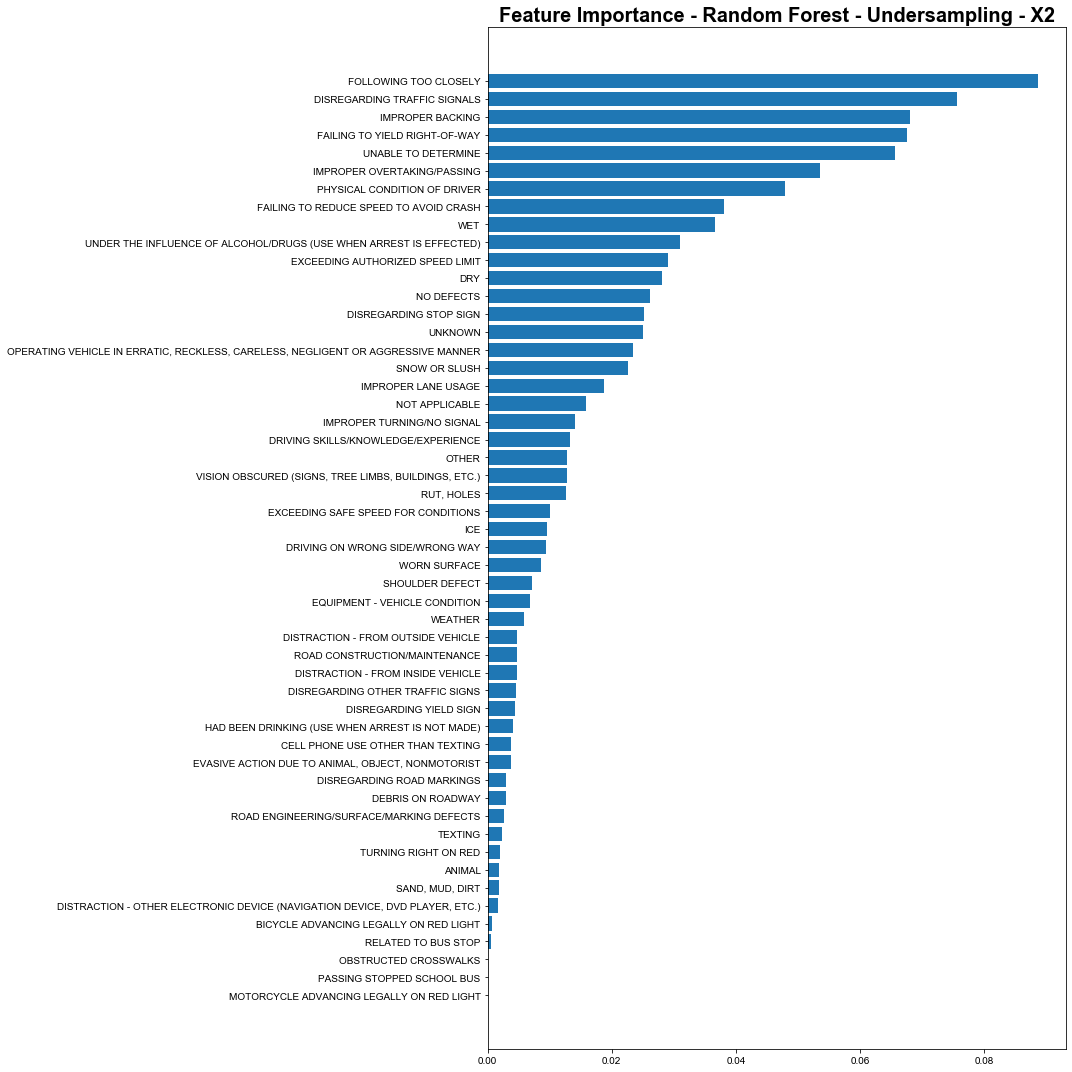

In [386]:
feat_imp_rf_us_2 = rf_rndm_us_2.feature_importances_
dct_imp_rf_us_2 = {}
for feat, val in zip(X_2_dum.columns, feat_imp_rf_us_2):
    dct_imp_rf_us_2[feat] = val
df_imp_rf_us_2 = pd.DataFrame(dct_imp_rf_us_2, index=[0]).unstack().reset_index()
df_imp_rf_us_2.drop('level_1', axis=1, inplace=True)
df_imp_rf_us_2.columns= ['feature', 'feat_importance']

df_imp_rf_us_2 = df_imp_rf_us_2.sort_values('feat_importance')

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(1, len(df_imp_rf_us_2)+1)

#plt.barh(pos_gdbt_2, energy, color='green', xerr=variance)
ax.barh(y=y_pos, width=df_imp_rf_us_2['feat_importance'])
       
ax.set_title("Feature Importance - Random Forest - Undersampling - X2", fontsize=20, fontweight='bold')
ax.yaxis.set_ticks(y_pos)
ax.set_yticklabels(labels=df_imp_rf_us_2['feature'])

fig.tight_layout();

---
### Logistic Regression - Undersampling - X1

In [429]:
std_scaler = StandardScaler()
X_1_train_rndm_us_scld = std_scaler.fit_transform(X_train_rndm_us)
X_1_test_scld = std_scaler.transform(X_1_test)

log_reg_1 = LogisticRegression(solver='lbfgs').fit(X_1_train_rndm_us_scld, y_train_rndm_us.ravel())
y_1_pred_log = log_reg_1.predict(X_1_test_scld)
print(classification_report(y_1_test.ravel(), y_1_pred_log))

              precision    recall  f1-score   support

           0       0.99      0.50      0.66     57345
           1       0.02      0.66      0.05      1071

    accuracy                           0.50     58416
   macro avg       0.51      0.58      0.36     58416
weighted avg       0.97      0.50      0.65     58416



---
### Logistic Regression - Undersampling - X2

In [360]:
std_scaler = StandardScaler()
X_2_train_rndm_us_scld = std_scaler.fit_transform(X_2_train_rndm_us)
X_2_test_scld = std_scaler.transform(X_2_test)

log_reg_2 = LogisticRegression(solver='lbfgs').fit(X_2_train_rndm_us_scld, y_train_rndm_us.ravel())
y_2_pred_log = log_reg_2.predict(X_2_test_scld)
print(classification_report(y_2_test.ravel(), y_2_pred_log))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     57345
           1       0.04      0.57      0.07      1071

    accuracy                           0.73     58416
   macro avg       0.51      0.65      0.46     58416
weighted avg       0.97      0.73      0.83     58416



---
## GridSearch

In [440]:
accidents2.head(2)

,CRASH_RECORD_ID,RD_NO,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,crash_date,crash_year,fatal_incap
0,00027e2894dd2f3fe4ff320a6d332d18e465b5c8ba2e79...,JC201794,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,2.0,16,4,3,2019-03-27 16:20:00,2019,0
1,0002fb938eb0feaea33820fa55b71e4ea0b332125e1510...,JB175900,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,2.0,15,3,3,2018-03-06 15:00:00,2018,0


In [ ]:
X_1_Grid = accidents2[['Crash_Hour', 'TRAFFIC_CONTROL_DEVICE', 'POSTED_SPEED_LIMIT', 'LIGHTING_CONDITION'